# PrintChakra - Document Processing Pipeline

A modular image processing pipeline for automated document detection, enhancement, and OCR.

## Section 1: Imports & Setup

Required libraries for computer vision, image processing, and OCR.

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import os
from typing import Tuple, List, Dict, Optional

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✅ OpenCV: {cv2.__version__} | NumPy: {np.__version__}")

✅ OpenCV: 4.10.0 | NumPy: 2.1.1


## Section 2: Utility Functions

Helper functions for image loading, visualization, and geometric transformations.

In [67]:
def load_or_create_sample(image_path: str = 'image.jpg') -> np.ndarray:
    """Load image or create synthetic sample"""
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            print(f"✅ Loaded: {image_path} ({img.shape[1]}x{img.shape[0]})")
            return img
    print("📝 Creating sample document...")
    sample = np.ones((800, 600, 3), dtype=np.uint8) * 240
    pts = np.array([[100, 150], [500, 120], [520, 650], [80, 680]], dtype=np.int32)
    cv2.fillPoly(sample, [pts], (255, 255, 255))
    for y in range(200, 400, 40):
        cv2.rectangle(sample, (150, y), (450, y+15), (30, 30, 30), -1)
    cv2.polylines(sample, [pts], True, (0, 0, 0), 5)
    os.makedirs('backend', exist_ok=True)
    cv2.imwrite('backend/sample_doc.jpg', sample)
    return sample

def show_images(images: List[Tuple[np.ndarray, str]], figsize: Tuple[int, int] = (16, 6)):
    """Display multiple images in a grid"""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, (img, title) in zip(axes, images):
        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def order_points(pts: np.ndarray) -> np.ndarray:
    """Sort quadrilateral corners to: top-left, top-right, bottom-right, bottom-left"""
    # Calculate center
    center = pts.mean(axis=0)
    
    # Calculate angles from center
    angles = np.arctan2(pts[:, 1] - center[1], pts[:, 0] - center[0])
    
    # Sort by angle (counter-clockwise from right)
    sorted_indices = np.argsort(angles)
    sorted_pts = pts[sorted_indices]
    
    # Reorder to start from top-left: find the point with minimum (x + y)
    sums = sorted_pts.sum(axis=1)
    min_sum_idx = np.argmin(sums)
    
    # Rotate array to start from top-left
    ordered = np.roll(sorted_pts, -min_sum_idx, axis=0)
    return ordered.astype("float32")

def four_point_transform(image: np.ndarray, pts: np.ndarray) -> np.ndarray:
    """Apply perspective correction via homography"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

print("✅ Utility functions loaded")

✅ Utility functions loaded


## Section 3: Document Detection

Multi-method document boundary detection with geometric scoring.

In [68]:
def refine_document_corners(image: np.ndarray, corners: np.ndarray, inset_pixels: int = 15) -> np.ndarray:
    """
    Refine detected corners by moving them inward to avoid shadow boundaries.
    This accounts for lighting gradients at document edges.
    """
    if corners is None or len(corners) != 4:
        return corners
    
    corners = corners.reshape(4, 2).astype(np.float32)
    
    # Calculate center of document
    center = corners.mean(axis=0)
    
    # Move each corner slightly toward center to account for shadows
    refined = corners.copy()
    for i in range(4):
        direction = center - corners[i]
        norm = np.linalg.norm(direction)
        if norm > 0:
            # Move inward by inset_pixels pixels
            direction = direction / norm
            refined[i] = corners[i] + direction * inset_pixels
    
    return refined.astype(np.int32)

def detect_document_refined(image: np.ndarray, debug: bool = False, inset: int = 12) -> Optional[np.ndarray]:
    """Document detection with corner refinement"""
    detected = detect_document(image, debug=debug)
    
    if detected is not None:
        detected_clean = detected.reshape(4, 2)
        refined = refine_document_corners(image, detected_clean, inset_pixels=inset)
        
        if debug:
            print(f"   Corners refined (inset: {inset}px)")
        
        return refined.reshape(4, 1, 2).astype('int32')
    
    return None

print("✅ Corner refinement module loaded")


✅ Corner refinement module loaded


## Section 3b: Corner Refinement

Post-process detected corners to account for shadows and improve accuracy.

In [69]:
def score_contour(contour: np.ndarray, image_shape: Tuple[int, int]) -> Dict:
    """Score contour based on geometric criteria - improved to avoid background edges"""
    area = cv2.contourArea(contour)
    image_area = image_shape[0] * image_shape[1]
    area_ratio = area / image_area
    height, width = image_shape
    pts = contour.reshape(-1, 2)
    
    # Margin analysis - STRICT: penalize edges touching the image boundary
    min_x, min_y = np.min(pts[:, 0]), np.min(pts[:, 1])
    max_x, max_y = np.max(pts[:, 0]), np.max(pts[:, 1])
    
    # Calculate margins as percentage of image size
    left_margin = min_x / width
    right_margin = (width - max_x) / width
    top_margin = min_y / height
    bottom_margin = (height - max_y) / height
    min_margin = min(left_margin, right_margin, top_margin, bottom_margin)
    
    # CRITICAL: Heavy penalty if edges are too close to image boundary
    if min_margin < 0.04:
        margin_score = -600  # Very strong penalty
    elif min_margin < 0.06:
        margin_score = -300  # Strong penalty
    elif min_margin < 0.12:
        margin_score = -50   # Mild penalty
    else:
        margin_score = 100   # Good margin
    
    # Rectangularity check
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box_area = cv2.contourArea(box)
    
    if box_area > 0:
        rectangularity = area / box_area
    else:
        rectangularity = 0
    
    # Angle analysis - measure how close corners are to 90 degrees
    angles = []
    for i in range(len(pts)):
        p0, p1, p2 = pts[i], pts[(i+1) % len(pts)], pts[(i+2) % len(pts)]
        v1, v2 = p0 - p1, p2 - p1
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 > 0 and norm2 > 0:
            angle = np.arccos(np.clip(np.dot(v1, v2) / (norm1 * norm2), -1, 1))
            angles.append(np.degrees(angle))
    
    if angles:
        angle_error = np.mean([abs(a - 90) for a in angles])
    else:
        angle_error = 180
    
    # Scoring for rectangularity
    if angle_error < 8:
        rect_score = 100
    elif angle_error < 12:
        rect_score = 60
    elif angle_error < 18:
        rect_score = 20
    else:
        rect_score = -100
    
    # Aspect ratio check (prefer close to 1:1.5 or similar)
    if rect[1][0] > 0 and rect[1][1] > 0:
        aspect = max(rect[1]) / min(rect[1])
        if 1.2 <= aspect <= 2.5:  # Document-like aspect ratio
            aspect_score = 40
        elif aspect > 2.5 or aspect < 1.2:
            aspect_score = -80
        else:
            aspect_score = 10
    else:
        aspect_score = 0
    
    # Area ratio scoring
    if 0.10 <= area_ratio <= 0.70:
        area_score = 100
    elif 0.08 <= area_ratio < 0.10 or 0.70 < area_ratio <= 0.80:
        area_score = 30
    elif area_ratio > 0.80:
        area_score = -400  # Too large, definitely capturing background
    else:
        area_score = -100  # Too small
    
    # Convexity check
    hull_area = cv2.contourArea(cv2.convexHull(contour))
    if hull_area > 0:
        solidity = area / hull_area
        if solidity > 0.96:
            solidity_score = 50
        elif solidity > 0.90:
            solidity_score = 20
        else:
            solidity_score = -60
    else:
        solidity_score = 0
    
    # Total score
    score = margin_score + rect_score + aspect_score + area_score + solidity_score
    
    return {
        'score': score,
        'area_ratio': area_ratio,
        'angle_error': angle_error,
        'min_margin': min_margin,
        'rectangularity': rectangularity,
        'margin_score': margin_score,
        'rect_score': rect_score,
        'area_score': area_score
    }

def detect_document(image: np.ndarray, debug: bool = False) -> Optional[np.ndarray]:
    """Document detection with strict margin filtering"""
    candidates = []
    orig_shape = image.shape[:2]
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Method 1: Canny edge detection with strict filtering
    for low, high in [(45, 125), (55, 160), (70, 200)]:
        edges = cv2.Canny(blurred, low, high)
        # Dilate to close small gaps
        edges = cv2.dilate(edges, np.ones((5, 5)), iterations=2)
        edges = cv2.erode(edges, np.ones((2, 2)), iterations=1)
        
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in contours:
            area = cv2.contourArea(c)
            if 8000 < area < image.shape[0] * image.shape[1] * 0.75:  # Filter by area range
                peri = cv2.arcLength(c, True)
                for epsilon in [0.015, 0.020, 0.028]:
                    approx = cv2.approxPolyDP(c, epsilon * peri, True)
                    if len(approx) == 4:
                        candidates.append((approx.reshape(4, 2), 'Canny', area))
    
    # Method 2: Adaptive thresholding
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY_INV, 17, 5)
    adaptive = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, np.ones((7, 7)), iterations=2)
    
    contours, _ = cv2.findContours(adaptive, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if 8000 < area < image.shape[0] * image.shape[1] * 0.75:
            peri = cv2.arcLength(c, True)
            for epsilon in [0.020, 0.028, 0.038]:
                approx = cv2.approxPolyDP(c, epsilon * peri, True)
                if len(approx) == 4:
                    candidates.append((approx.reshape(4, 2), 'Adaptive', area))
    
    if not candidates:
        if debug:
            print("⚠️ No valid contours found")
        return None
    
    # Score all candidates
    scored = []
    for quad, method, area in candidates:
        scores = score_contour(quad.reshape(4, 1, 2), orig_shape)
        scored.append((quad, method, scores['score'], scores))
    
    # Sort by score
    scored.sort(key=lambda x: x[2], reverse=True)
    
    if debug and len(scored) > 0:
        best = scored[0]
        print(f"✅ Document detected (score: {best[2]:.1f})")
        print(f"   Margin: {best[3]['min_margin']:.3f}")
        print(f"   Area ratio: {best[3]['area_ratio']:.3f}")
        print(f"   Angle error: {best[3]['angle_error']:.1f}°")
    
    # Return best candidate if acceptable score
    if scored[0][2] > 50:
        return scored[0][0].astype('int32').reshape(4, 1, 2)
    
    return None

print("✅ Document detection loaded (improved v3)")


✅ Document detection loaded (improved v3)


## Section 4: Image Enhancement

Contrast enhancement and OCR preprocessing.

In [70]:
def enhance_contrast(image: np.ndarray, brightness: int = 25, eq_strength: float = 0.4) -> np.ndarray:
    """Multi-stage contrast enhancement"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    brightened = cv2.convertScaleAbs(gray, alpha=1.0, beta=brightness)
    equalized_full = cv2.equalizeHist(brightened)
    equalized = cv2.addWeighted(brightened, 1.0 - eq_strength, equalized_full, eq_strength, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_enhanced = clahe.apply(equalized)
    return cv2.addWeighted(equalized, 0.5, clahe_enhanced, 0.5, 0)

def preprocess_for_ocr(image: np.ndarray) -> List[Tuple[np.ndarray, str]]:
    """Generate OCR-ready preprocessing variants for handwritten & printed text"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    variants = []
    
    # Bilateral filter for noise reduction while preserving edges
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)
    variants.append((bilateral, 'bilateral'))
    
    # Adaptive thresholding with different block sizes for varying text sizes
    adaptive1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    variants.append((adaptive1, 'adaptive_11'))
    
    adaptive2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 3)
    variants.append((adaptive2, 'adaptive_15'))
    
    # CLAHE + Sharpening for handwriting
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(bilateral)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)
    sharpened_thresh = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2)
    variants.append((sharpened_thresh, 'clahe_sharpened'))
    
    # High contrast for handwriting
    clahe_high = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast = clahe_high.apply(bilateral)
    contrast_thresh = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)
    variants.append((contrast_thresh, 'high_contrast'))
    
    return variants

print("✅ Enhancement module loaded")

✅ Enhancement module loaded


## Section 5: OCR Processing

Multi-configuration text extraction using Tesseract.

In [71]:
def extract_text_multi_config(image: np.ndarray, debug: bool = False) -> Tuple[str, Dict]:
    """Extract text with multiple OCR configurations"""
    configs = [
        ('PSM 3 (Auto)', '--oem 3 --psm 3'),
        ('PSM 6 (Block)', '--oem 3 --psm 6'),
        ('PSM 4 (Column)', '--oem 3 --psm 4')
    ]
    variants = preprocess_for_ocr(image)
    results = []
    
    try:
        for img, variant_name in variants:
            for config_name, config_str in configs:
                text = pytesseract.image_to_string(img, lang='eng', config=config_str)
                results.append({
                    'text': text,
                    'length': len(text.strip()),
                    'config': config_name,
                    'variant': variant_name
                })
        
        best = max(results, key=lambda x: x['length'])
        if debug:
            print(f"✅ Best OCR: {best['config']} ({best['variant']}) - {best['length']} chars")
        
        data = pytesseract.image_to_data(variants[0][0], output_type=pytesseract.Output.DICT)
        words = [w for w in data['text'] if w.strip()]
        lines = set(data['line_num'])
        
        stats = {
            'chars': len(best['text']),
            'words': len(words),
            'lines': len(lines),
            'config': best['config']
        }
        return best['text'], stats
    except Exception as e:
        if debug:
            print(f"OCR error: {e}")
        return "", {}

print("✅ OCR module loaded")

✅ OCR module loaded


## Section 6: Complete Pipeline

End-to-end document processing workflow.

In [72]:
def process_document(image_path: str = 'image.jpg', output_path: str = 'output.jpg',
                     visualize: bool = True, extract_ocr: bool = True, strict: bool = True) -> Dict:
    """Complete 5-stage document processing pipeline"""
    print("=" * 70)
    print("📸 PRINTCHAKRA DOCUMENT PROCESSING PIPELINE")
    print("=" * 70)
    
    # Stage 1: Load
    print("\n[1/5] Loading image...")
    original = load_or_create_sample(image_path)
    if visualize:
        show_images([(original, 'Original Image')])
    
    # Stage 2: Detect & Refine
    print("\n[2/5] Detecting document boundaries...")
    doc_contour = detect_document_refined(original, debug=True, inset=12)
    
    if doc_contour is not None:
        doc_contour_pts = doc_contour.reshape(4, 2).astype(np.float32)
        if visualize:
            preview = original.copy()
            cv2.drawContours(preview, [doc_contour.astype(int)], -1, (0, 255, 0), 5)
            show_images([(original, 'Original'), (preview, 'Detected')])
        processed = four_point_transform(original, doc_contour_pts)
        print(f"✅ Cropped: {processed.shape[1]}x{processed.shape[0]}")
    else:
        print("⚠️ No document detected, using original")
        processed = original
    
    # Stage 3: Enhance
    print("\n[3/5] Enhancing image quality...")
    enhanced = enhance_contrast(processed, brightness=25, eq_strength=0.4)
    if visualize:
        show_images([
            (cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY), 'Before'),
            (enhanced, 'After Enhancement')
        ])
    
    # Stage 4: Extract text
    text, stats = "", {}
    if extract_ocr:
        print("\n[4/5] Extracting text (OCR)...")
        text, stats = extract_text_multi_config(processed, debug=True)
        if text.strip():
            print(f"\n📄 Text: {stats.get('chars', 0)} chars, {stats.get('words', 0)} words")
            print("-" * 70)
            print(text[:200] + ("..." if len(text) > 200 else ""))
            print("-" * 70)
    
    # Stage 5: Save
    print("\n[5/5] Saving processed image...")
    cv2.imwrite(output_path, enhanced, [cv2.IMWRITE_JPEG_QUALITY, 95])
    file_size = os.path.getsize(output_path) / 1024
    print(f"✅ Saved: {output_path} ({file_size:.1f} KB)")
    
    if visualize:
        show_images([(original, 'Original'), (processed, 'Cropped'), (enhanced, 'Enhanced')], figsize=(18, 6))
    
    print("\n" + "=" * 70)
    print("✅ PROCESSING COMPLETE")
    print("=" * 70)
    
    return {
        'original_shape': original.shape,
        'processed_shape': processed.shape,
        'output_path': output_path,
        'file_size_kb': file_size,
        'text': text,
        'ocr_stats': stats
    }

print("✅ Pipeline loaded (with refined detection)")


✅ Pipeline loaded (with refined detection)


## Section 7: Execute

Run the complete pipeline on a document image.

📸 PRINTCHAKRA DOCUMENT PROCESSING PIPELINE

[1/5] Loading image...
✅ Loaded: image.jpg (1080x1920)


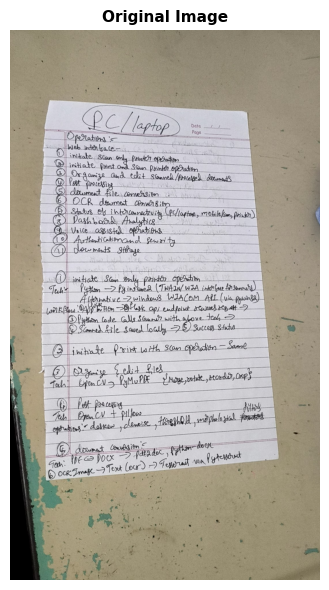


[2/5] Detecting document boundaries...
✅ Document detected (score: 240.0)
   Margin: 0.113
   Area ratio: 0.464
   Angle error: 4.3°
   Corners refined (inset: 12px)


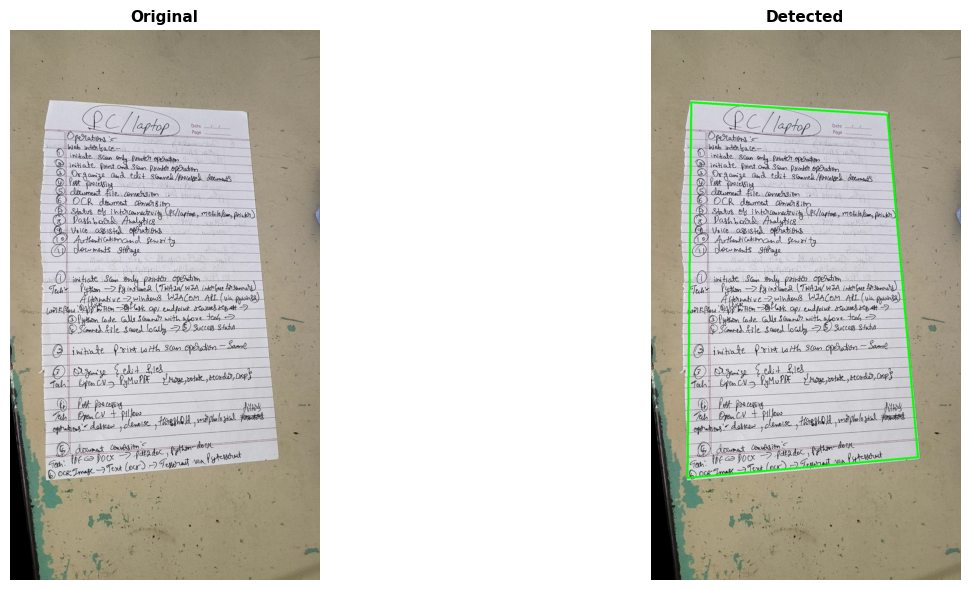

✅ Cropped: 806x1311

[3/5] Enhancing image quality...


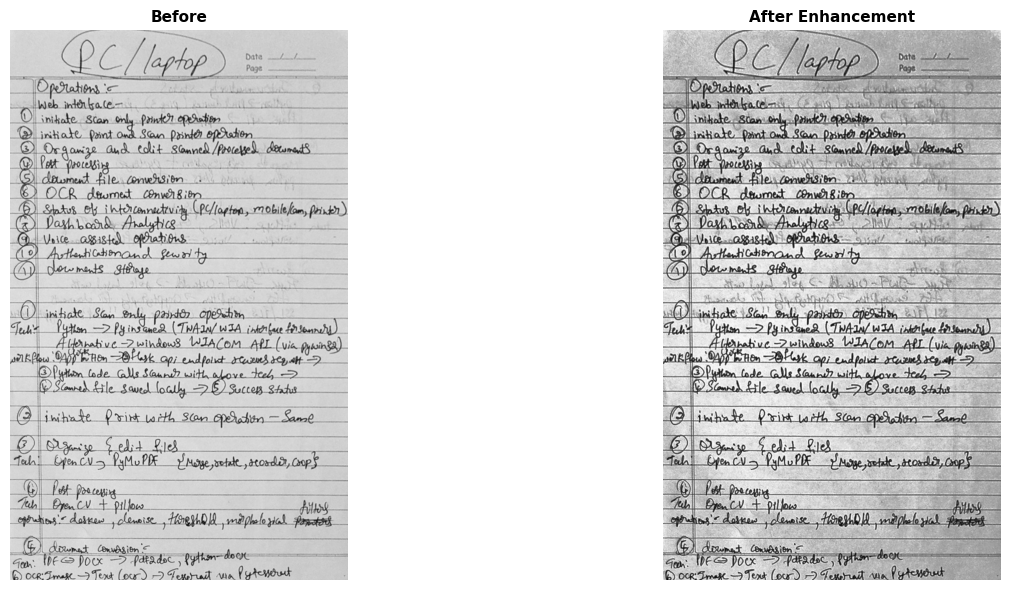


[4/5] Extracting text (OCR)...
✅ Best OCR: PSM 6 (Block) (clahe_sharpened) - 873 chars

📄 Text: 874 chars, 162 words
----------------------------------------------------------------------
OC > =
SO [SIE On Ween eee certo
eed ee (eee ne Cape AR ce
EOE Bid aNE Scanlon cp Hie ease eames
ISAO CT ddr op Sabon OE Na
BOOS weary Waes eh crall Moraye aaron gee
Mar Sages io eee en
TIGER SRC Wie ...
----------------------------------------------------------------------

[5/5] Saving processed image...
✅ Saved: output.jpg (542.5 KB)


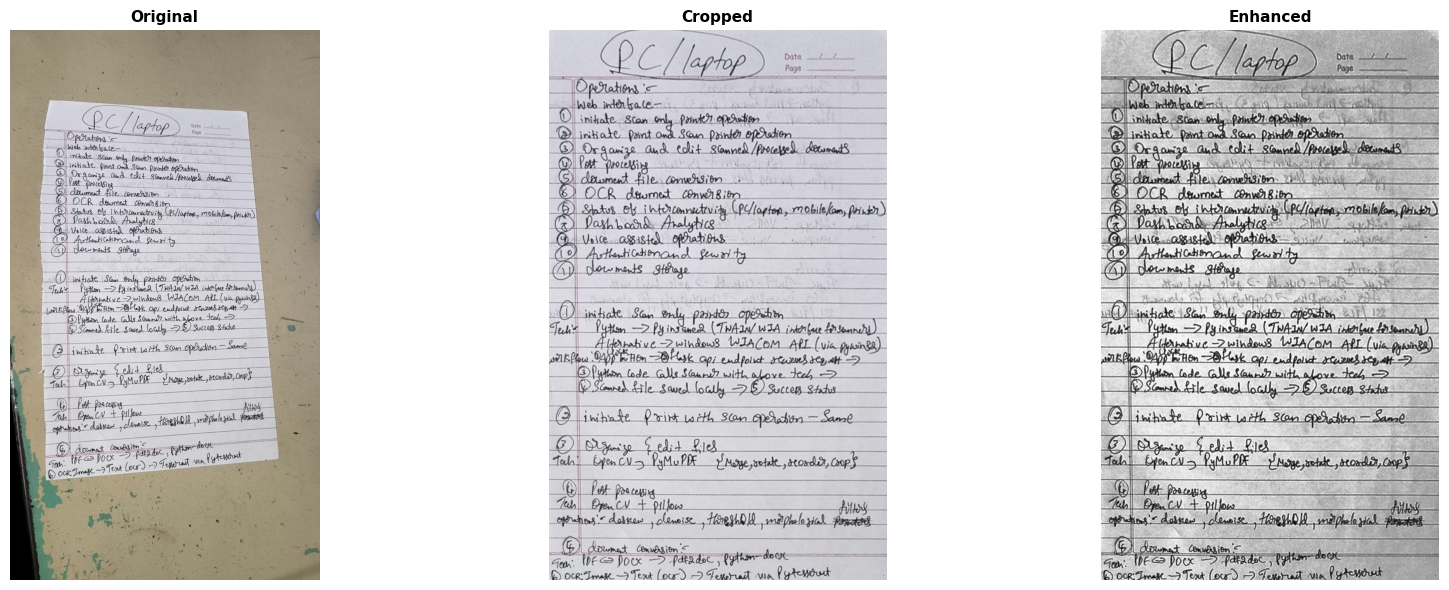


✅ PROCESSING COMPLETE

📊 PROCESSING SUMMARY
   Original: 1080x1920
   Processed: 806x1311
   Output: output.jpg (542.5 KB)
   OCR: 162 words, 9 lines


In [73]:
# Execute pipeline
results = process_document(
    image_path='image.jpg',
    output_path='output.jpg',
    visualize=True,
    extract_ocr=True,
    strict=True
)

# Summary
print(f"\n📊 PROCESSING SUMMARY")
print(f"   Original: {results['original_shape'][1]}x{results['original_shape'][0]}")
print(f"   Processed: {results['processed_shape'][1]}x{results['processed_shape'][0]}")
print(f"   Output: {results['output_path']} ({results['file_size_kb']:.1f} KB)")
if results.get('ocr_stats'):
    print(f"   OCR: {results['ocr_stats'].get('words', 0)} words, {results['ocr_stats'].get('lines', 0)} lines")